# Multiomics Visualisation (across species, within omics)

For more information please contact [Ignatius Pang](mailto:i.pang@unsw.edu.au) or [Tyrone Chen](mailto:tyrone.chen@monash.edu) or [Sonika Tyagi](mailto:sonika.tyagi@monash.edu).

## Table of contents
1. [Information for biologists](#biologists)
2. [Information for bioinformaticians](#bioinformaticians)
3. [Information for methods section](#methods)

## UpSetPlots

### Information for biologists <a name="biologists"></a>
UpSetPlots are a visualisation method which can be interpreted as a quantitative venn diagram. [More information on the method can be found in the original 2014 publication](https://rdcu.be/bO4oV), and a [sample interactive UpSetPlot on unrelated data is available here](https://vdl.sci.utah.edu/upset2/embed.html#{"NavBar":false,"FilterBox":false,"DataSetInfo":false,"LeftSideBar":true,"RightSideBar":false,"ProvenanceView":false,"DeviationBars":true,"CardinalityBars":true}).

### Information for bioinformaticians <a name="bioinformaticians"></a>
Implementations exist in [javascript](https://github.com/VCG/upset), [python](https://pypi.org/project/UpSetPlot/) and [R](https://github.com/hms-dbmi/UpSetR). For this `python` implementation the requirements is just `upsetplot` which can be installed with:

```
pip install upsetplot
```
or
```
conda install upsetplot -c conda-forge
```

While the following libraries are also required, they should get installed automatically when installing the UpSetPlot library through conda:
```
matplotlib
numpy
pandas
```
[OPTIONAL] If using a jupyter notebook in a `conda` or other virtual environment, the following library can be used to easily switch kernels:
```
nb_conda=2.2.1
```

### Information for methods section <a name="methods"></a>
*Add details of camera, gsea, metaboanalyst workflows here*

In [1]:
# The raw code for this IPython notebook is by default hidden for easier reading.
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import numpy
import pandas
from matplotlib import pyplot as plt
from upsetplot import from_contents, from_memberships, plot, generate_counts, UpSet
%matplotlib inline


For the input data, we use information generated by Ignatius Pang previously in the files: 

| Analysis type | File name     | MD5   |
| ------------- |:-------------:| -----:|
| Camera        | KEGG_camera_test_all_results.tsv | 0f2f8bc04d91ee9fa7eed32b72a04aab |
| GSEA          | KEGG_gsea_test_all_results.tsv      |  dae99150e7310a9557b5a36bc8b10c17  |
| MetaboAnalystR | MetaboAnalystR_enriched_kegg_pathways.tsv      |    9ad2df3c6d7a6275dc5f2d8617c67617 |
| (reference) KEGG pathway mappings | map_title.tab | 7f124dca6613dcd266a686b68c27ca2f |

### Process data

1. [Drop invalid or incomparable values (eg NaN)](#1)
2. [Filter each table](#2)
3. [Preprocess each table and pool all data](#3)
4. [Aggregate species](#4)
5. [Map omics to direction](#5)
6. [Parse data into UpSetPlot compatible format (all species)](#6)
7. [Plot UpSet plots for kegg pathways across the different omics (all species)](#7)
8. [Export top intersecting pathways (all species)](#8)
9. [Parse data into UpSetPlot compatible format (individual species)](#9) 
10. [Plot UpSet plots for kegg pathways across the different omics (individual species)](#10)
11. [Export top intersecting pathways (individual species)](#11)

### [Notes on data](#notes)

* Presence of null values in camera data
* Rescuing metabolomics data by merging regulation states
* Removal of some conditions
* Pathways present in just one dataset are counted

### Summary

#### 1. Drop invalid or incomparable values  <a name="1"></a>

In the case of camera analysis, some p values were invalid and these were dropped. In the case of GSEA, NA values corresponded to comparison group which does not affect this workflow. In the case of MetaboAnalystR, NA values corresponded to KEGG pathway ids. To rescue this, we will need to map kegg pathway names back onto ids.

In [3]:
# source data was processed by Ignatius Pang
camera_path = "KEGG_camera_test_all_results.tsv"
gsea_path = "KEGG_gsea_test_all_results.tsv"
metar_path = "MetaboAnalystR_enriched_kegg_pathways.tsv"
camera = pandas.read_csv(camera_path, sep="\t")
gsea = pandas.read_csv(gsea_path, sep="\t")
metar = pandas.read_csv(metar_path, sep="\t")

proteomics_columns = ["Proteomics MS1 DDA", "Proteomics MS2 DIA/SWATH" ]

gsea = gsea[ gsea['Type_of_Experiment'].isin ( proteomics_columns)   ]


# show how many invalid values were discarded
dim_camera_full = camera.shape
dim_gsea_full = gsea.shape
dim_metar_full = metar.shape
camera.dropna(inplace=True)
# gsea.dropna(inplace=True)
# metar.dropna(inplace=True)
dim_camera_less = camera.shape
dim_gsea_less = gsea.shape
dim_metar_less = metar.shape

print(str(dim_camera_full[0] - dim_camera_less[0]), "of", 
      dim_camera_full[0], "rows containing invalid p values were dropped")
print(str(dim_gsea_full[0] - dim_gsea_less[0]), "of", 
      dim_gsea_full[0], "rows containing invalid values were dropped")
print(str(dim_metar_full[0] - dim_metar_less[0]), "of", 
      dim_metar_full[0], "rows containing invalid values were dropped")

0 of 2643 rows containing invalid p values were dropped
0 of 85 rows containing invalid values were dropped
0 of 2413 rows containing invalid values were dropped


#### 2. Filter each table <a name="2"></a>

Filter data based on criteria of interest. For Camera and MetaboAnalystR, we remove everything that falls under an FDR threhsold of 0.05. For GSEA we remove everything that falls under an adjusted p value of 0.05.

In [4]:
# we want to filter out pathways of interest
# filter out the data points of interest

def filter_data(data, filter_unit, threshold):
    """
    Takes pandas dataframe as input, filter criteria and threshold.
    
    Arguments:
        data = a pandas dataframe of values
        filter_unit = column heading to filter by (eg p-val, FDR, ...)
        threshold = anything not meeting this threshold is removed
    """
    original_dim = data.shape
    filtered_data = data.loc[data[filter_unit] < threshold]
    filtered_dim = filtered_data.shape
    print(" ".join([
        "Removed", str(original_dim[0] - filtered_dim[0]), "of", 
        str(original_dim[0]), "values not meeting threshold of", 
        str(filter_unit), str(threshold)
    ]))
    removed_strain = set(data["Strain"].unique()) - \
                      set(filtered_data["Strain"].unique())
    if len(removed_strain) > 0:
        print("Strain", removed_strain, "did not pass filtering for a dataset!")
    return filtered_data

camera_filtered = filter_data(camera, "FDR", 0.05)
gsea_filtered = filter_data(gsea, "p.adjust", 0.05)
metar_filtered = filter_data(metar, "FDR", 0.05)

Removed 2272 of 2643 values not meeting threshold of FDR 0.05
Removed 0 of 85 values not meeting threshold of p.adjust 0.05
Removed 2063 of 2413 values not meeting threshold of FDR 0.05
Strain {'04153260899A', 'PS006', 'HKU419', '5448', 'SP444', 'PS003'} did not pass filtering for a dataset!


#### 3. Preprocess each table and pool data <a name="3"></a>

With GSEA, up and down regulated values are assigned by the enrichment score, where a positive value is interpreted as upregulation and a negative value is interpreted as downregulation.

With MetaboAnalystR, information on Up vs Down regulation states for metabolomics data was not possible to obtain due to limitations in the analysis method.

In [5]:
# for GSEA, assign regulatory state based on enrichment score values
gsea_filtered.loc[gsea_filtered["enrichmentScore"] >= 0, "Direction"] = "Up"
gsea_filtered.loc[gsea_filtered["enrichmentScore"] < 0, "Direction"] = "Down"

# kegg pathway id is a float here, force int for consistency with other files
metar_filtered.dropna(inplace=True)
metar_filtered["kegg_pathway_id"] = metar_filtered["kegg_pathway_id"].astype(int)

# no direction information is available, but for pooling we create "Unknown"
metar_filtered["Direction"] = "Unknown Regulation Direction metabolomics only"

# only keep columns that intersect across the datasets
camera_intersect = camera_filtered.drop(["entity_type", "NGenes", "PValue",
                                         "contrast", "kegg_pathway_id"], axis=1)
gsea_intersect = gsea_filtered.drop(["ID", "setSize", "enrichmentScore", 
                                     "NES", "pvalue", "qvalues", "rank", 
                                     "leading_edge", "core_enrichment", 
                                     "Comparisons"], axis=1)
metar_intersect = metar_filtered.drop(["kegg_reference_species_id", "kegg_pathway_id",
                                       "Total Cmpd", "Hits", "-log(p)", 
                                       "Holm adjust", "Raw p", "Impact"], axis=1)

# make sure column names are consistent (order is important here!)
camera_intersect.columns = ["Species", "Strain", "Type_of_Experiment", 
                            "Direction", "FDR", "Kegg_pathway_name"]
gsea_intersect.columns = ["Species", "Strain", "Type_of_Experiment", 
                          "Kegg_pathway_name", "FDR", "Direction"]
metar_intersect.columns = ["Species", "Strain", "Type_of_Experiment", 
                           "Kegg_pathway_name", "FDR", "Direction"]

# pool the data now that columns are consistent
pooled_data = pandas.concat([camera_intersect, gsea_intersect, metar_intersect], sort=True)
pooled_data = pooled_data[["Species", "Strain", "Type_of_Experiment", 
                           "Kegg_pathway_name", "Direction", "FDR"]]

print("The filtered, pooled data has the shape:", str(pooled_data.shape),
      "\nAnd columns:", str(pooled_data.columns.values))
pooled_data.head()

The filtered, pooled data has the shape: (794, 6) 
And columns: ['Species' 'Strain' 'Type_of_Experiment' 'Kegg_pathway_name' 'Direction'
 'FDR']


Species Strain Type_of_Experiment  \
0  Escherichia coli    B36            RNA-Seq   
1  Escherichia coli    B36            RNA-Seq   
2  Escherichia coli    B36            RNA-Seq   
3  Escherichia coli    B36            RNA-Seq   
4  Escherichia coli    B36            RNA-Seq   

                          Kegg_pathway_name Direction           FDR  
0                                  Ribosome      Down  2.146956e-37  
1  Pentose and glucuronate interconversions        Up  3.604667e-04  
2               Aminoacyl-tRNA biosynthesis      Down  5.158529e-04  
3                      Galactose metabolism        Up  8.311612e-04  
4           Lipopolysaccharide biosynthesis      Down  8.311612e-04

#### 4. Aggregate species <a name="4"></a>

For this workflow, we are mainly interested in comparing kegg pathways of strains within each omics instead of species.

In [6]:
# we already filtered on raw p values so we no longer need these
pooled_data_omic = pooled_data.drop(["FDR"], axis=1)
pooled_data_omic["Species_Strain"] = pooled_data_omic["Species"] + " " + pooled_data_omic["Strain"]
pooled_data_omic.head()

# each block requires a custom string replacement
# metabolomics block, also split into subsets based on regulation state (up or down)
metabolomics = pooled_data_omic[pooled_data_omic.Type_of_Experiment.str.startswith("Metabolomics")]
metabolomics["Type_of_Experiment"] = "Metabolomics"
metabolomics["Type_of_Experiment_Direction"] = metabolomics["Type_of_Experiment"] + " " + metabolomics["Direction"]
metabolomics_un = metabolomics[metabolomics["Direction"] == "Unknown Regulation Direction metabolomics only"]
metabolomics_up = metabolomics[metabolomics["Direction"] == "Up"]
metabolomics_dn = metabolomics[metabolomics["Direction"] == "Down"]
assert (metabolomics.shape[0]) == (metabolomics_up.shape[0] + metabolomics_dn.shape[0] + metabolomics_un.shape[0]), "Total pathways surveyed should be the same"

# collapse instruments into omics type
proteomics = pooled_data_omic[pooled_data_omic.Type_of_Experiment.str.startswith("Proteomics")]
proteomics["Type_of_Experiment"] = "Proteomics"
proteomics["Type_of_Experiment_Direction"] = proteomics["Type_of_Experiment"] + " " + proteomics["Direction"]
proteomics_up = proteomics[proteomics["Direction"] == "Up"]
proteomics_dn = proteomics[proteomics["Direction"] == "Down"]
assert (proteomics.shape[0]) == (proteomics_up.shape[0] + proteomics_dn.shape[0]), "Total pathways surveyed should be the same"

# rnaseq block, also split into subsets based on regulation state (up or down)
rna_seq = pooled_data_omic[pooled_data_omic.Type_of_Experiment.str.startswith("RNA-Seq")]
rna_seq["Type_of_Experiment"] = "RNA-Seq"
rna_seq["Type_of_Experiment_Direction"] = rna_seq["Type_of_Experiment"] + " " + rna_seq["Direction"]
rna_seq_up = rna_seq[rna_seq["Direction"] == "Down"]
rna_seq_dn = rna_seq[rna_seq["Direction"] == "Up"]
assert (rna_seq.shape[0]) == (rna_seq_up.shape[0] + rna_seq_dn.shape[0]), "Total pathways surveyed should be the same"

pooled_data_omic = pandas.concat([rna_seq, metabolomics, proteomics], sort=True)
pooled_data_omic_direction = pandas.concat([rna_seq_up, rna_seq_dn, metabolomics_un, metabolomics_up, metabolomics_dn, proteomics_up, proteomics_dn], sort=True)

#### 5. Map omics to direction <a name="5"></a>

In [7]:
# to get unique indices, aggregate columns
def _split_experiment_type(data):
    """
    Take a pandas dataframe and return aggregated data 
    Assumes some hardcoded column values, do not edit!
    
    Arguments:
        data = pandas dataframe
        column_name = column name in dataframe
        start_string = starting string for column value
            Finds all values starting with this string
            Then replaces all instances to this string
    """
    dim_start = data.shape
    data["Omics_Direction"] = \
        data["Type_of_Experiment"] + " " + data["Direction"]

    assert dim_start[0] == data.shape[0], \
        "Some values were dropped, doublecheck data state!"
    return data

before_omic = pooled_data_omic.shape
before_omic_direction = pooled_data_omic_direction.shape
pooled_data_omic.drop_duplicates(inplace=True)
pooled_data_omic_direction.drop_duplicates(inplace=True)

print(str(before_omic[0] - pooled_data_omic.shape[0]), "duplicates removed")
print(str(before_omic_direction[0] - pooled_data_omic_direction.shape[0]), "duplicates removed")

# this is already mapped, drop
pooled_data_omic = pooled_data_omic.drop(["Direction"], axis=1).sort_index()
pooled_data_omic_direction = pooled_data_omic_direction.drop(["Direction"], axis=1).sort_index()
pooled_data_omic_direction.head()


40 duplicates removed
40 duplicates removed


Kegg_pathway_name           Species  \
0                                         Ribosome  Escherichia coli   
0                              Nitrogen metabolism  Escherichia coli   
0      Valine, leucine and isoleucine biosynthesis  Escherichia coli   
1  Chlorocyclohexane and chlorobenzene degradation  Escherichia coli   
1         Glycine, serine and threonine metabolism  Escherichia coli   

             Species_Strain   Strain Type_of_Experiment  \
0      Escherichia coli B36      B36            RNA-Seq   
0  Escherichia coli MS14384  MS14384         Proteomics   
0      Escherichia coli B36      B36       Metabolomics   
1  Escherichia coli MS14384  MS14384         Proteomics   
1      Escherichia coli B36      B36       Metabolomics   

                        Type_of_Experiment_Direction  
0                                       RNA-Seq Down  
0                                    Proteomics Down  
0  Metabolomics Unknown Regulation Direction meta...  
1                                    Proteomics Down  
1  Metabolomics Unknown Regulation Direction meta...

#### 6. Parse data into UpSetPlot compatible format (all species) <a name="6"></a>


In [8]:
# some helper functions are defined here to automate repetitive tasks
def _reformat_data_for_upsetplot(data, column):
    """
    Take a dataframes to be plotted, desired categories, return labelled list of reformatted dataframes
    """
    omics_kegg = data
    omics = omics_kegg[column].unique()
    omics.sort()
    omics_kegg = [omics_kegg[omics_kegg[column].str.contains(omic)] for omic in omics]
    collapse_kegg = lambda x: "|".join(x).split("|")
    omics_kegg = [omic_kegg.groupby(omic_kegg["Species_Strain"]).aggregate({'Kegg_pathway_name':collapse_kegg}) 
                  for omic_kegg in omics_kegg]
    before = [omic.shape[0] for omic in omics_kegg]
    omics_kegg = [omic_kegg.loc[omic_kegg.astype(str).drop_duplicates().index] for omic_kegg in omics_kegg]
    after = [omic.shape[0] for omic in omics_kegg]
    duplicates_dropped = [i - j for i, j in zip(before, after)]
    duplicates_per_exp = list(zip(omics, duplicates_dropped))

    # removes pathways duplicated within a single strain
    temp = list()
    for omic in omics_kegg:
        omic["Kegg_pathway_name"] = omic["Kegg_pathway_name"].apply(set).apply(list).apply(sorted)
        temp.append(omic)
    omics_kegg = temp
    [print(omic, "as one plot") for omic in omics]
    return list(zip(omics, omics_kegg))

    # display non-overlapping strains
#     sp = data["Strain"]
#     sp_unique = sp.unique()
#     sp_unique.sort()
#     dropped_sp = [list(x) for x in 
#                   [set(sp_unique) - set(index) for index in [omic.index for omic in omics_kegg]]]
#     dropped_sp = list(zip(omics, dropped_sp))
#     [print("\nStrain dropped from", omic, "data as they had no KEGG pathway overlap:\n",
#            "(note that this includes ALL strains regardless of species)", 
#            pandas.DataFrame(sp)) for omic, sp in dropped_sp]

# we treat kegg pathway id as strings
# pooled_data_reg["Kegg_pathway_name"] = pooled_data_reg["Kegg_pathway_name"].astype(str)
print("Note that strains with non-overlapping KEGG pathways are removed!\n")
pooled_data_omic_for_upsetplot = _reformat_data_for_upsetplot(pooled_data_omic, "Type_of_Experiment")
pooled_data_omic_direction_for_upsetplot = _reformat_data_for_upsetplot(pooled_data_omic_direction, "Type_of_Experiment_Direction")

for i, j in enumerate(pooled_data_omic_for_upsetplot):
    if len(j[1]) < 2:
        print("There are are less than 2 comparable strains for condition:", j[0], "- removing!")
        del pooled_data_omic_for_upsetplot[i]
        
for i, j in enumerate(pooled_data_omic_direction_for_upsetplot):
    if len(j[1]) < 2:
        print("There are are less than 2 comparable strains for condition:", j[0], "- removing!")
        del pooled_data_omic_direction_for_upsetplot[i]

Note that strains with non-overlapping KEGG pathways are removed!

Metabolomics as one plot
Proteomics as one plot
RNA-Seq as one plot
Metabolomics Unknown Regulation Direction metabolomics only as one plot
Proteomics Down as one plot
Proteomics Up as one plot
RNA-Seq Down as one plot
RNA-Seq Up as one plot


#### 7. Plot UpSet plots for kegg pathways across the different omics (all species) <a name="7"></a>

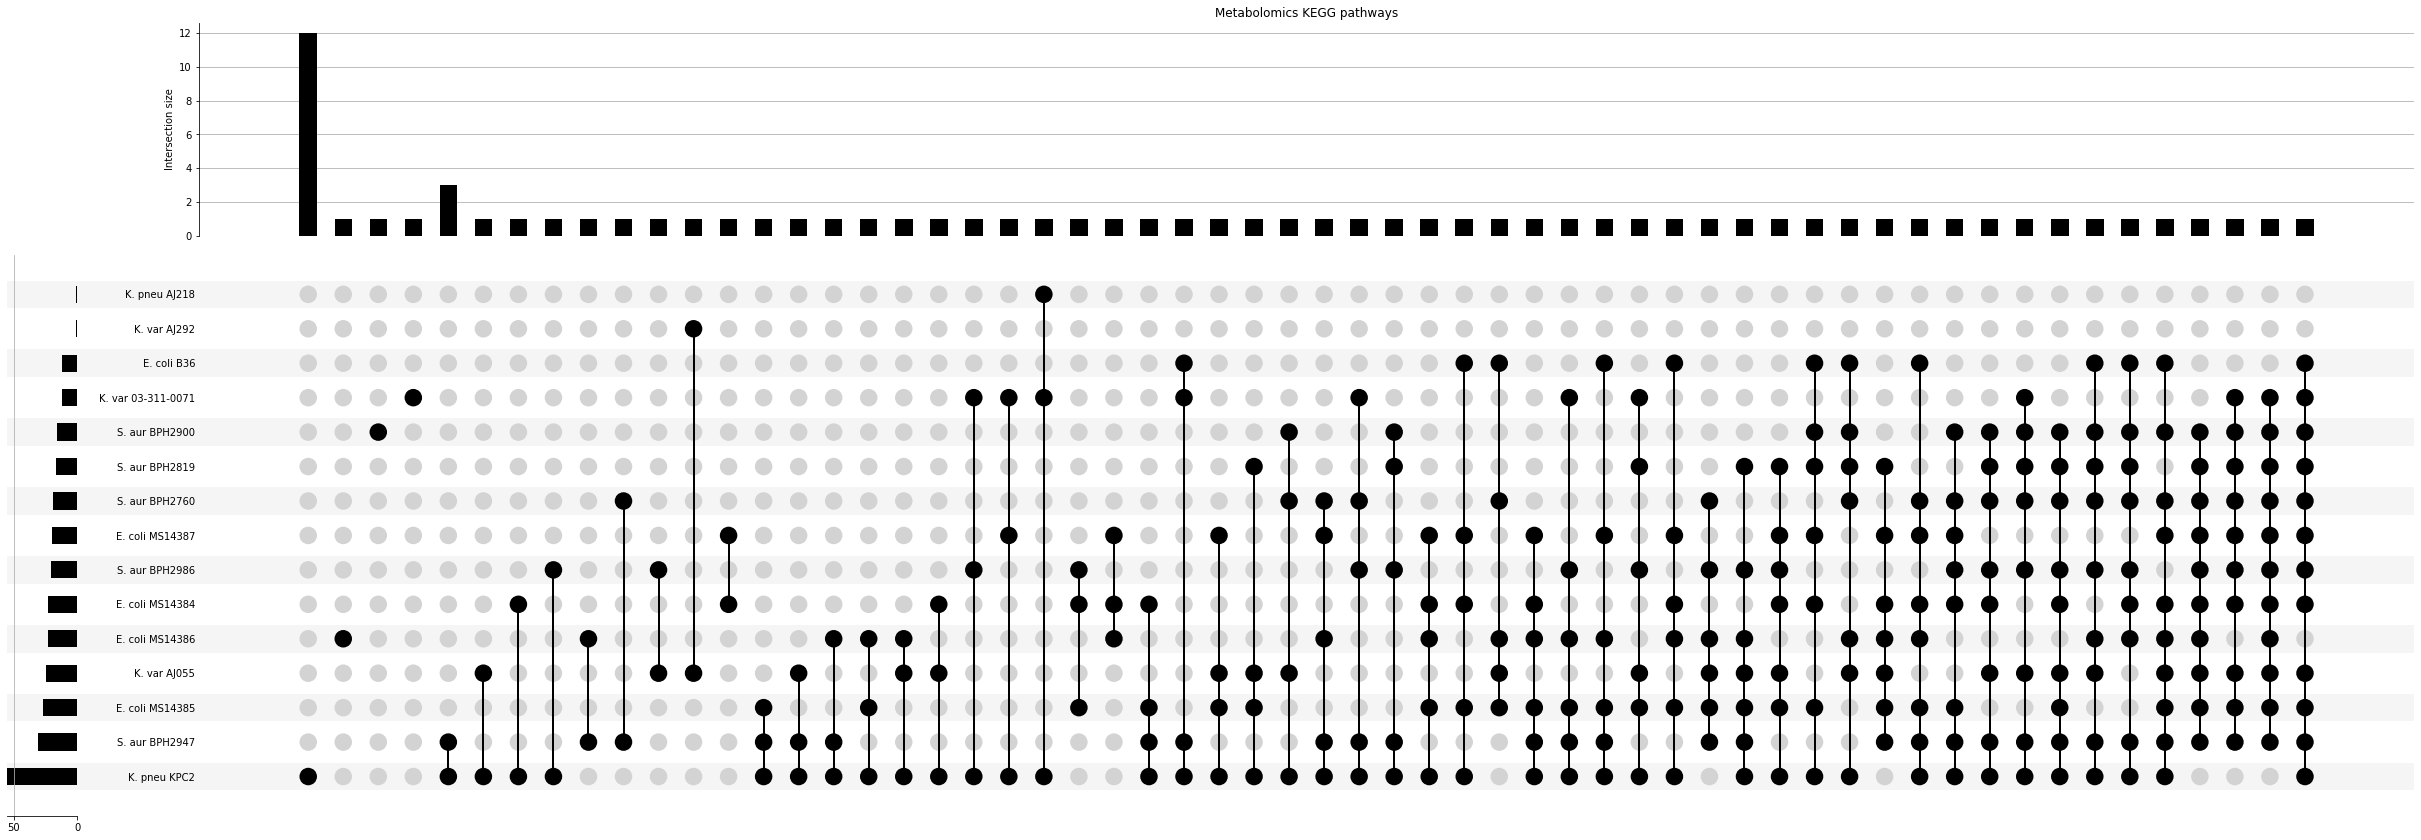

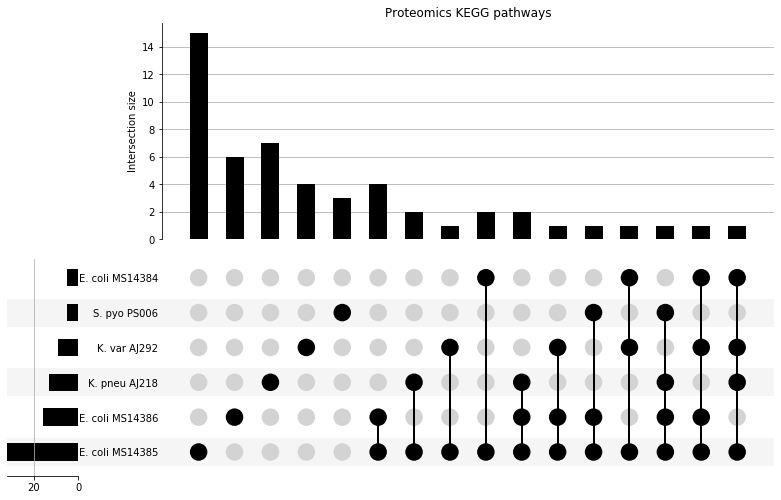

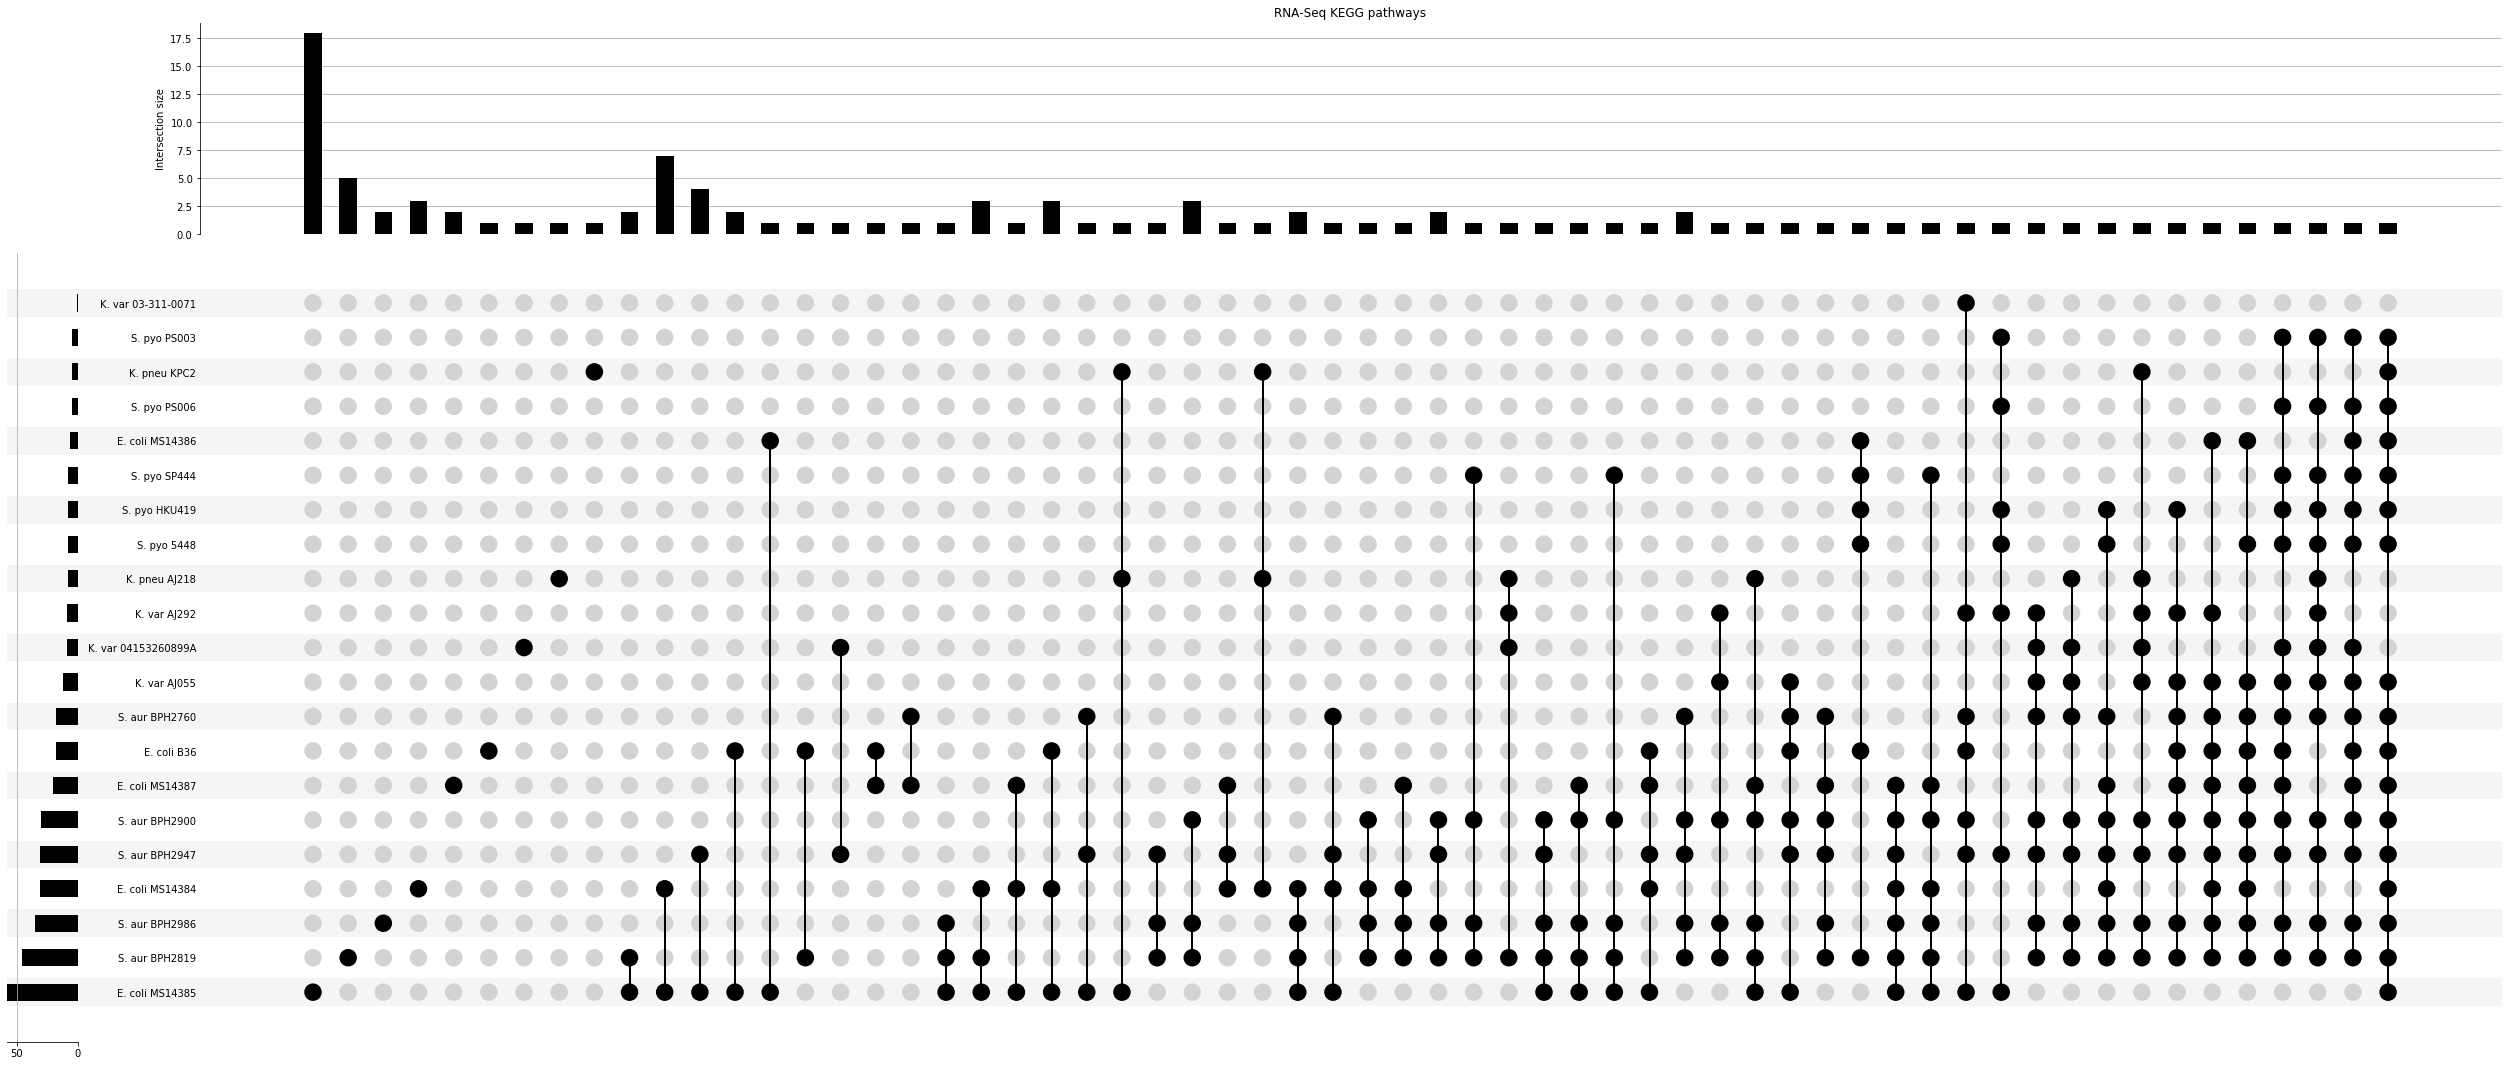

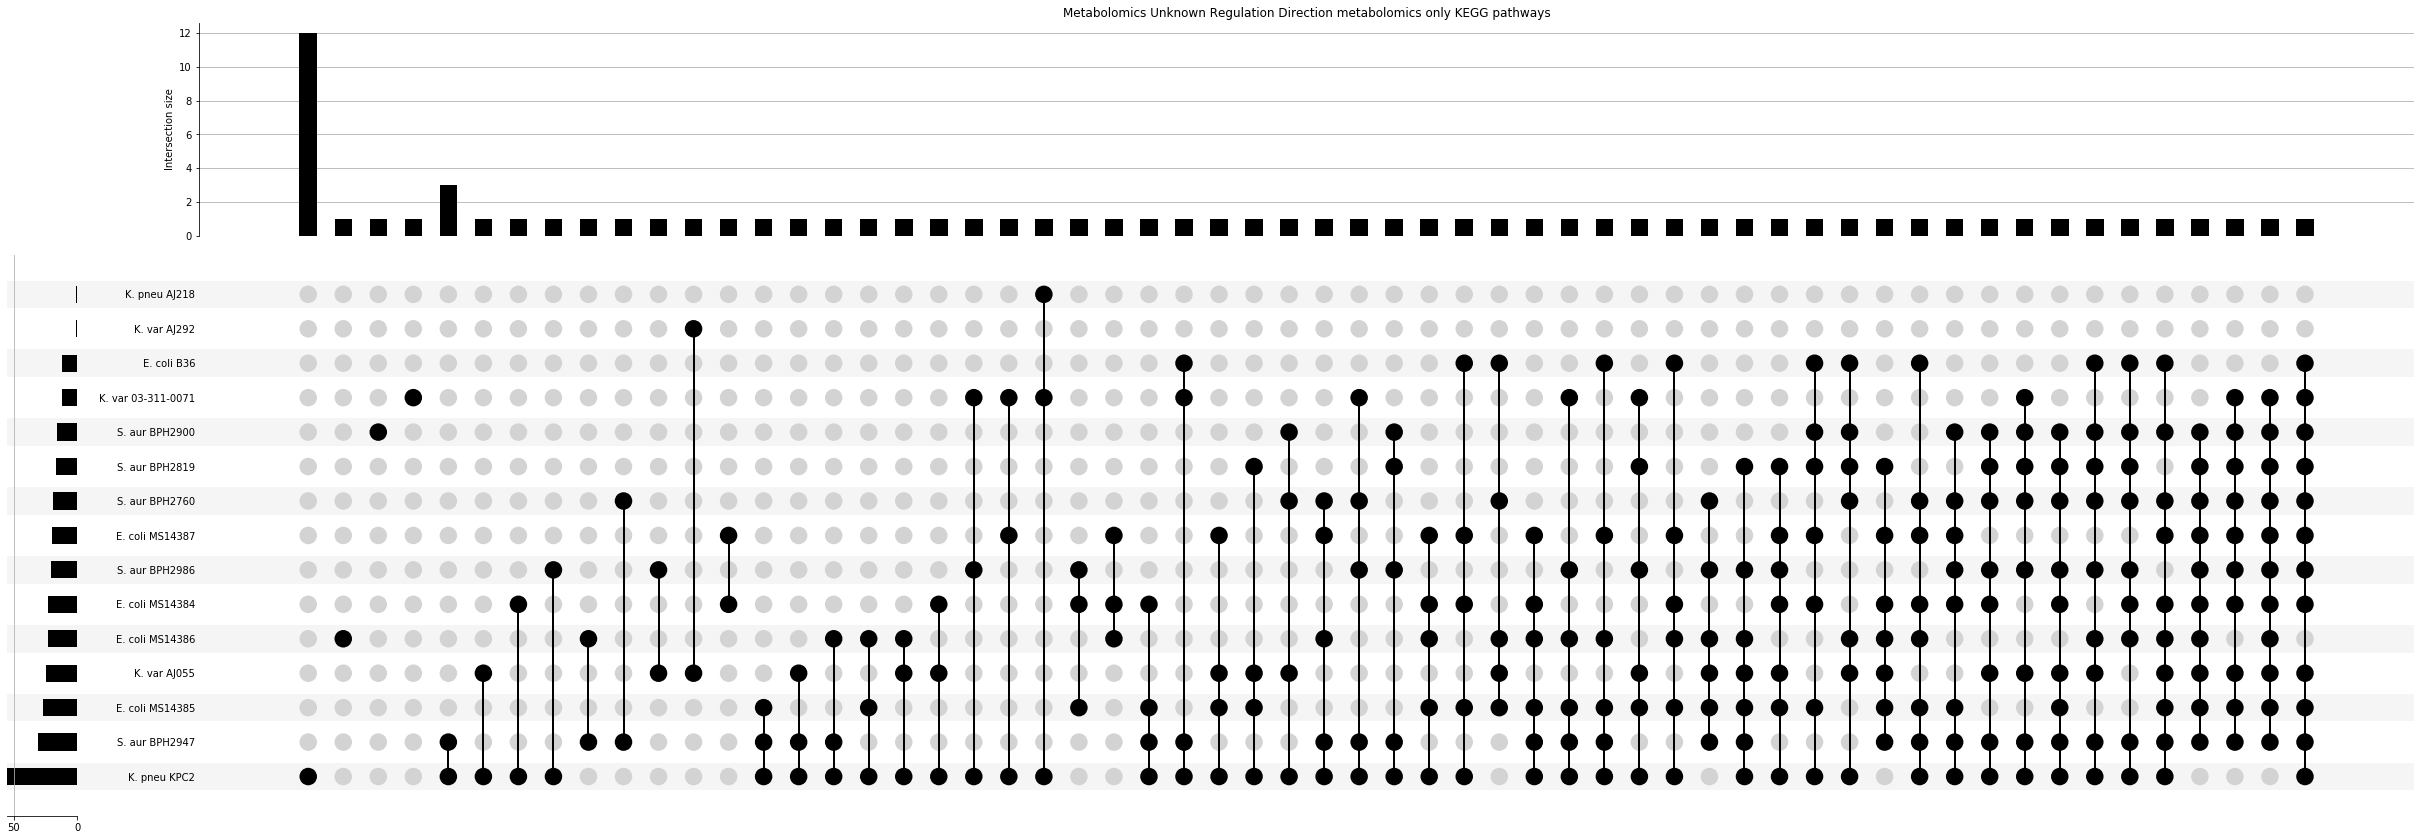

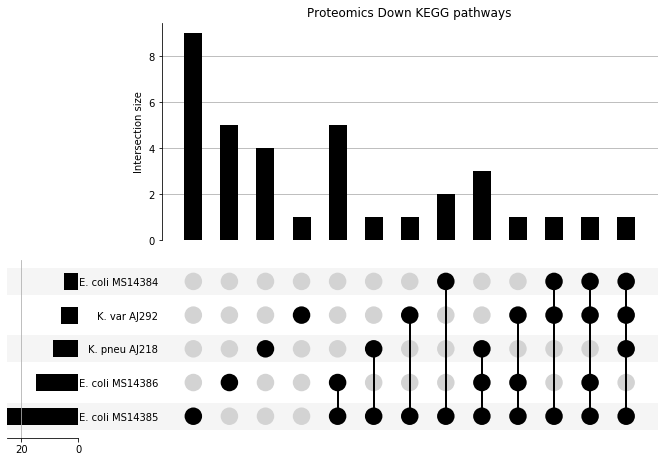

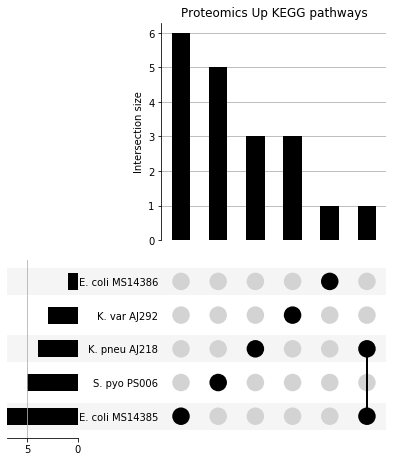

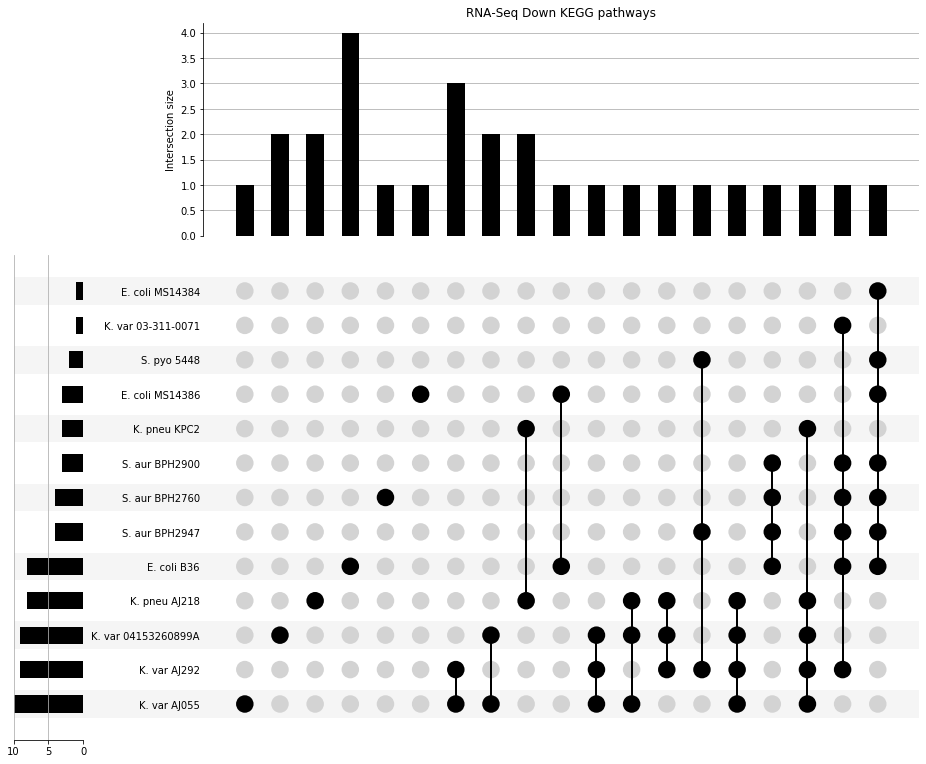

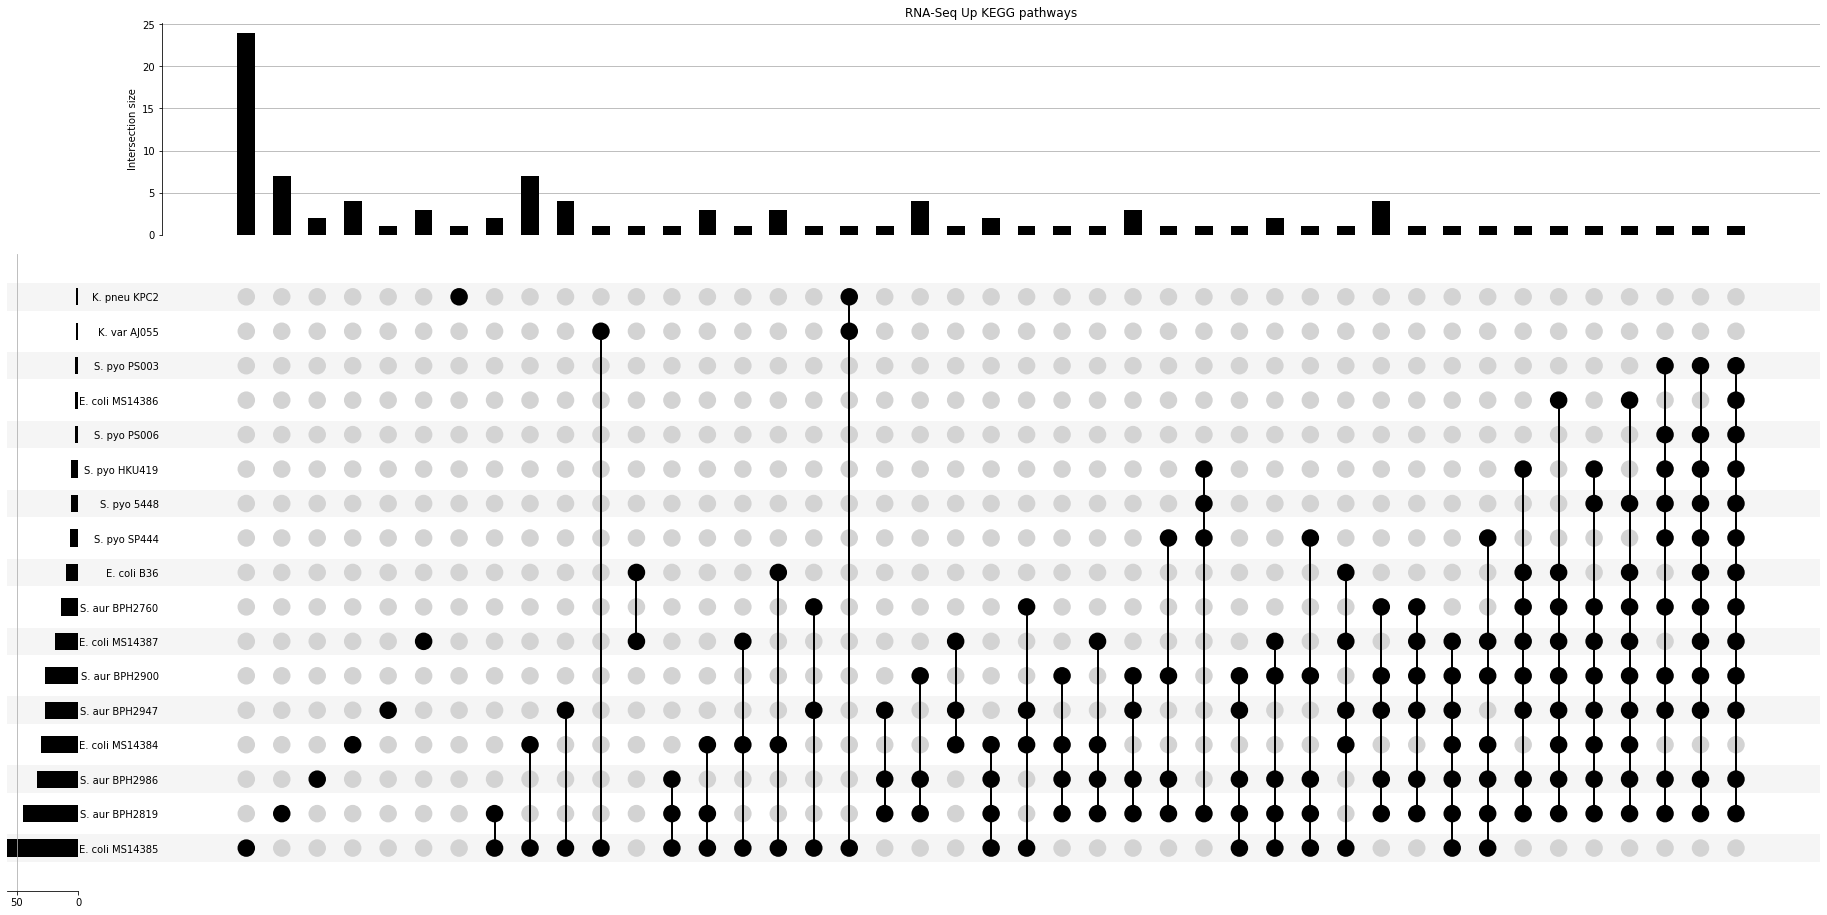

In [9]:
def _make_upsetplot(data, index):
    """
    Take list of label, dataframe, plot upsetplots
    """
    for plt_title, strain_multiomic in data:
        # legends too long and run off page, shorten
        strain_multiomic.reset_index(inplace=True)
        old_index = strain_multiomic["Species_Strain"].tolist()
        assert len(set([plt_title])) is 1, "There seems to be more than one species present within one comparison"

        # shorten items to prevent legends going off page
        shortened = [
            ("Escherichia coli", "E. coli"), 
            ("Klebsiella pneumoniae", "K. pneu"),
            ("Klebsiella variicola", "K. var"), 
            ("Staphylococcus aureus", "S. aur"), 
            ("Streptococcus pneumoniae", "S. pneu"),
            ("Streptococcus pyogenes", "S. pyo")
        ] 
        new_index = list()    
        for omic in old_index:
            for long, short in shortened:
                omic = omic.replace(long, short)
            new_index.append(omic)

        strain_multiomic[index] = new_index
        strain_multiomic.set_index(index, inplace=True)

        # reformat data to UpSetPlot format
        strain_multiomic = strain_multiomic.to_dict()['Kegg_pathway_name']
        strain_multiomic = from_contents(strain_multiomic)
        if( len(strain_multiomic) > 1): 
            upset = UpSet(strain_multiomic, subset_size='count', element_size=50)#, intersection_plot_elements=3)
            upset.plot()
            plt.title(" ".join([plt_title, "KEGG pathways"]))
            plt.show()

# run these lines if you want to get data for all species at once        
_make_upsetplot(pooled_data_omic_for_upsetplot, "Type_of_Experiment")
_make_upsetplot(pooled_data_omic_direction_for_upsetplot, "Type_of_Experiment_Direction")



#### 8. Export top intersecting pathways (all species) <a name="8"></a>

Here we show the biochemical pathways which have the most intersections (top 0.95 percentile) across **all omics and regulatory data for each strain** within an omics type. These are further subdivided into regulatory state (up or down regulated or unknown* or all combined)

- Escherichia coli
- Klebsiella pneumoniae
- Klebsiella variicola
- Staphylococcus aureus
- Streptococcus pneumoniae
- Streptococcus pyogenes

**Due to limitations in third-party analysis software, direction of regulation was not possible to obtain for some pathways*

In [10]:
# helper function to automate extraction of desired quantile values
def extract_pathway_by_intersections(data, quantile=0.95):
    """
    Take upsetplot compatible dataframe, filtering criteria, return pathways of interest
    
    Arguments:
        data = upsetplot compatible dataframe (output of _reformat_data_for_upsetplot)
        quantile = take the top N percentile of pathways (above this threshold)
    """
    data = from_contents(data.to_dict()["Kegg_pathway_name"]).reset_index().set_index(["id"]).astype(int)
    data["intersections_count"] = data.sum(axis=1)
    assert type(quantile) is float or type(quantile) is int, "Please input a value in the range of [0,1]"
    data = data[data["intersections_count"] >= data["intersections_count"].quantile(quantile)]
    data = pandas.DataFrame(data["intersections_count"]).reset_index()
    data.columns.values[0] = "pathway_id_KEGG"
    return data.set_index("pathway_id_KEGG")

quantile = 0.95
most_intersections = list()
for name, path in pooled_data_omic_for_upsetplot:
    most_intersections.append((name, extract_pathway_by_intersections(path, quantile)))
    
# export tsv files of pathways:quantity of intersections across strains
for name, path in most_intersections:
    print(name, "= quantile", quantile ,"of pathways which overlap across strains:\n", path["intersections_count"], "\n")
    path.to_csv("_".join(["All_species", "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")
    
quantile = 0.95
most_intersections = list()
for name, path in pooled_data_omic_direction_for_upsetplot:
    most_intersections.append((name, extract_pathway_by_intersections(path, quantile)))
    
# export tsv files of pathways:quantity of intersections across strains
for name, path in most_intersections:
    print(name, "= quantile", quantile ,"of pathways which overlap across strains:\n", path["intersections_count"], "\n")
    path.to_csv("_".join(["All_species", "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")

Metabolomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Amino sugar and nucleotide sugar metabolism    10
Aminoacyl-tRNA biosynthesis                    12
Arginine and proline metabolism                10
Galactose metabolism                           11
Streptomycin biosynthesis                      10
Name: intersections_count, dtype: int64 

Proteomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Nitrogen metabolism            4
Xylene degradation             4
Biosynthesis of antibiotics    4
Name: intersections_count, dtype: int64 

RNA-Seq = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Ascorbate and aldarate metabolism           11
Galactose metabolism                        15
Pentose and glucuronate interconversions    11
Phosphotransferase system (PTS)             14
Ribosome                                    17
Starch and sucrose metabolism               14
Name: intersections_count, d

#### 9. Parse data into UpSetPlot compatible format (individual species) <a name="9"></a>


In [11]:
def split_species(data, column, value):
    """
    Take dataframe, filter column, return new dataframe
    
    Arguments:
        data = dataframe
        column = filter on this column
        value = extract value of interest
    """
    return data[data[column] == value]

def _make_upsetplot(data, index):
    """
    Take list of label, dataframe, plot upsetplots
    """
    for plt_title, strain_multiomic in data:
        # legends too long and run off page, shorten
        strain_multiomic.reset_index(inplace=True)
        old_index = strain_multiomic["Species_Strain"].tolist()
        assert len(set([plt_title])) is 1, "There seems to be more than one species present within one comparison"

        # shorten items to prevent legends going off page
        shortened = [
            ("Escherichia coli", "E. coli"), 
            ("Klebsiella pneumoniae", "K. pneu"),
            ("Klebsiella variicola", "K. var"), 
            ("Staphylococcus aureus", "S. aur"), 
            ("Streptococcus pneumoniae", "S. pneu"),
            ("Streptococcus pyogenes", "S. pyo")
        ] 
        new_index = list()    
        for omic in old_index:
            for long, short in shortened:
                omic = omic.replace(long, short)
            new_index.append(omic)

        strain_multiomic[index] = new_index
        strain_multiomic.set_index(index, inplace=True)

        # reformat data to UpSetPlot format
        strain_multiomic = strain_multiomic.to_dict()['Kegg_pathway_name']
        # print(strain_multiomic)
        # print(len(strain_multiomic))
        ## Add condtion to print the UpSet plot if it has more than 1 species
        if ( len(strain_multiomic) > 1): 
            strain_multiomic = from_contents(strain_multiomic)
            #print(strain_multiomic)
            upset = UpSet(strain_multiomic, subset_size='count', element_size=50)#, intersection_plot_elements=3)
            upset.plot()
            plt.title(" ".join([plt_title, "KEGG pathways"]))
            plt.show()
        
# helper function to automate extraction of desired quantile values
def extract_pathway_by_intersections(data, quantile=0.95):
    """
    Take upsetplot compatible dataframe, filtering criteria, return pathways of interest
    
    Arguments:
        data = upsetplot compatible dataframe (output of _reformat_data_for_upsetplot)
        quantile = take the top N percentile of pathways (above this threshold)
    """
    data = from_contents(data.to_dict()["Kegg_pathway_name"]).reset_index().set_index(["id"]).astype(int)
    data["intersections_count"] = data.sum(axis=1)
    assert type(quantile) is float or type(quantile) is int, "Please input a value in the range of [0,1]"
    data = data[data["intersections_count"] >= data["intersections_count"].quantile(quantile)]
    data = pandas.DataFrame(data["intersections_count"]).reset_index()
    data.columns.values[0] = "pathway_id_KEGG"
    return data.set_index("pathway_id_KEGG")

species = pooled_data_omic["Species"].unique().tolist()
species = [split_species(pooled_data_omic, "Species", sp) for sp in species]    

#### 10. Plot UpSet plots for kegg pathways across the different omics (individual species) <a name="10"></a>

Here we show the biochemical pathways which have the most intersections (top 0.95 percentile) across all omics and regulatory data for each species within an omics type. These are further subdivided into regulatory state (up or down regulated or unknown* or all combined)

    Escherichia coli
    Klebsiella pneumoniae
    Klebsiella variicola
    Staphylococcus aureus
    Streptococcus pneumoniae
    Streptococcus pyogenes
    
#### 11. Export top intersecting pathways (individual species) <a name="11"></a>


Metabolomics as one plot
Proteomics as one plot
RNA-Seq as one plot
Metabolomics Unknown Regulation Direction metabolomics only as one plot
Proteomics Down as one plot
Proteomics Up as one plot
RNA-Seq Down as one plot
RNA-Seq Up as one plot


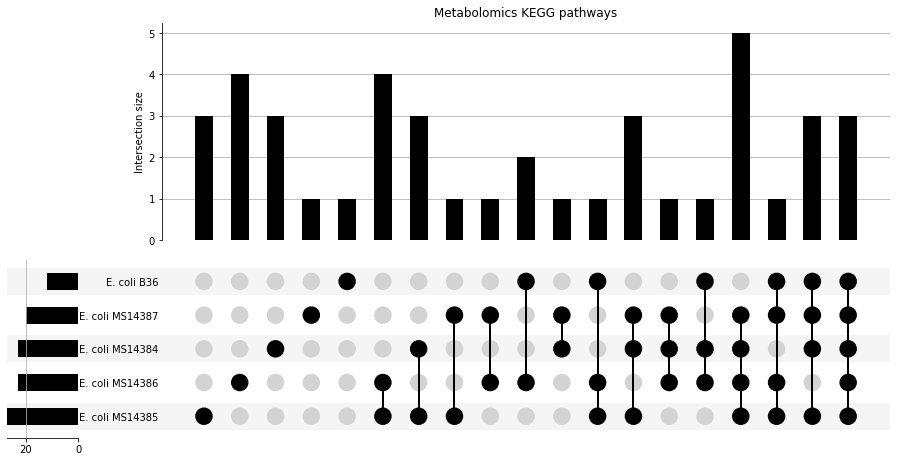

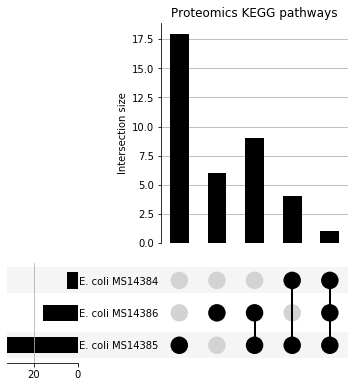

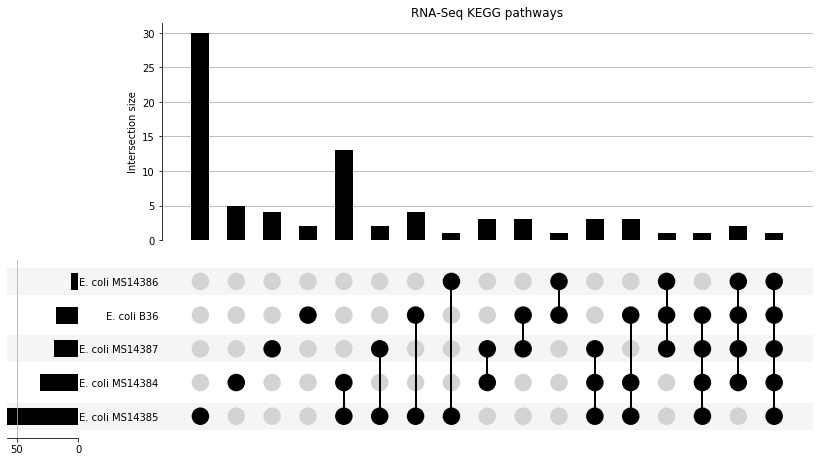

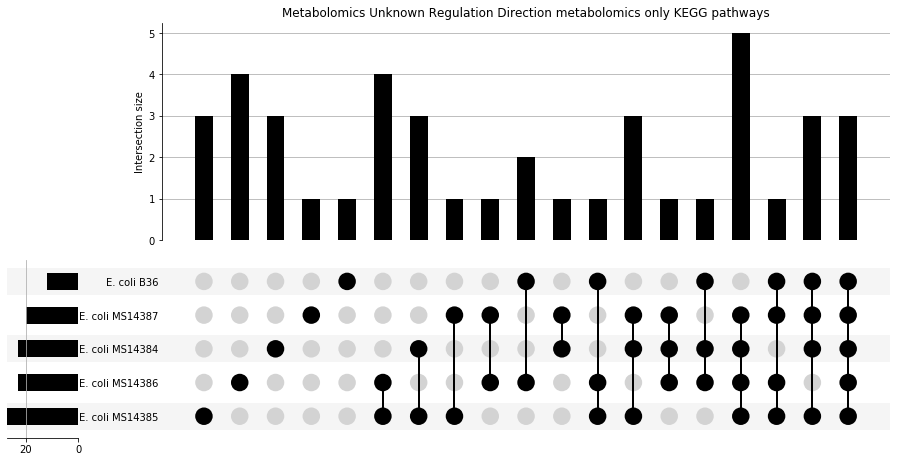

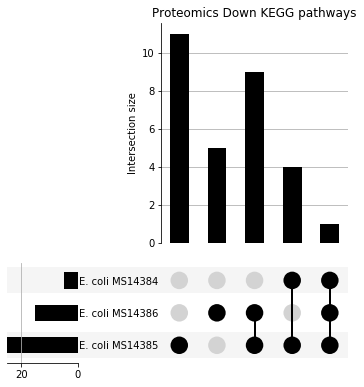

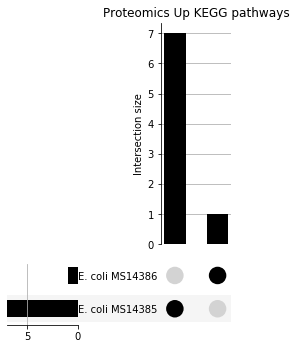

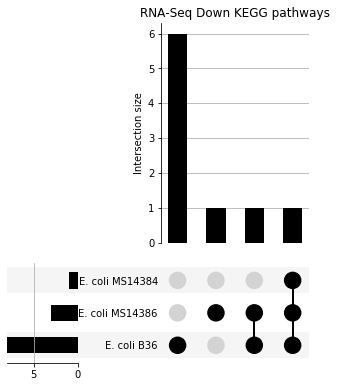

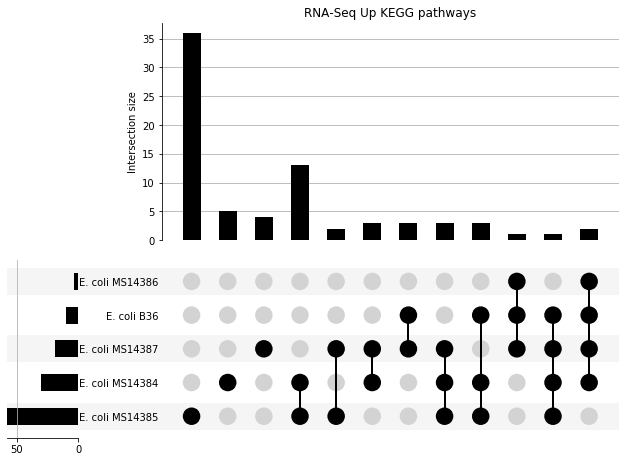

Metabolomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Amino sugar and nucleotide sugar metabolism    5
D-Alanine metabolism                           5
Peptidoglycan biosynthesis                     5
Name: intersections_count, dtype: int64 

Proteomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Biosynthesis of unsaturated fatty acids            2
Chlorocyclohexane and chlorobenzene degradation    2
Nitrogen metabolism                                2
Toluene degradation                                2
Xylene degradation                                 3
Alanine, aspartate and glutamate metabolism        2
Amino sugar and nucleotide sugar metabolism        2
Biosynthesis of amino acids                        2
Biosynthesis of antibiotics                        2
Biosynthesis of secondary metabolites              2
One carbon pool by folate                          2
Phenylalanine metabolism                           2
P

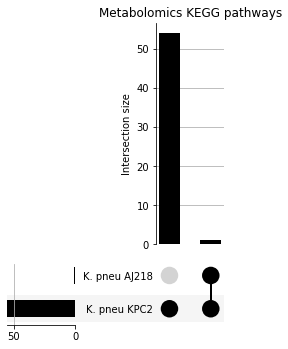

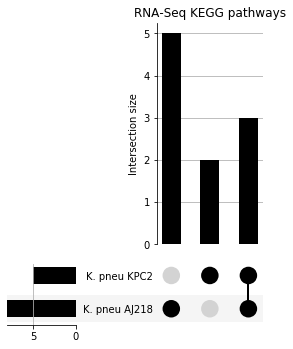

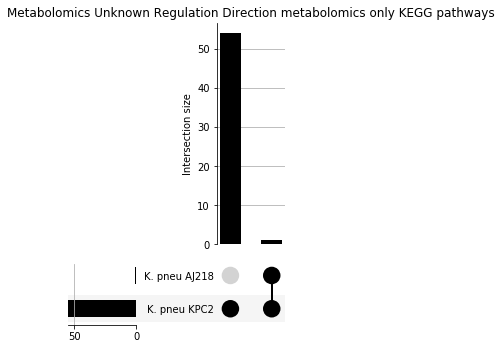

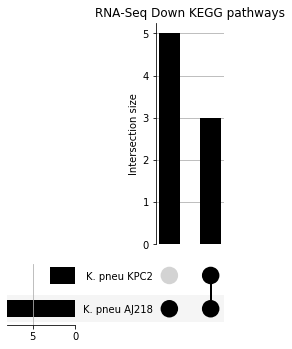

Metabolomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Benzoate degradation                                   2
Alanine, aspartate and glutamate metabolism            1
Amino sugar and nucleotide sugar metabolism            1
Aminoacyl-tRNA biosynthesis                            1
Ascorbate and aldarate metabolism                      1
Biosynthesis of unsaturated fatty acids                1
Butanoate metabolism                                   1
C5-Branched dibasic acid metabolism                    1
Carbapenem biosynthesis                                1
Citrate cycle (TCA cycle)                              1
Cyanoamino acid metabolism                             1
Cysteine and methionine metabolism                     1
D-Alanine metabolism                                   1
D-Glutamine and D-glutamate metabolism                 1
Dioxin degradation                                     1
Fatty acid biosynthesis                                1


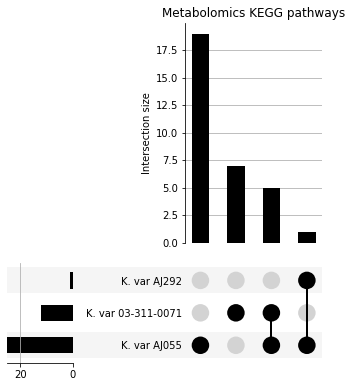

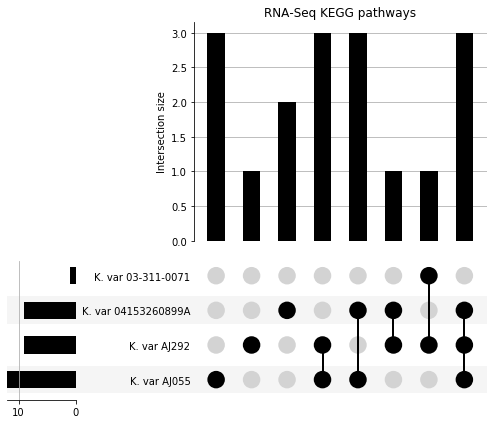

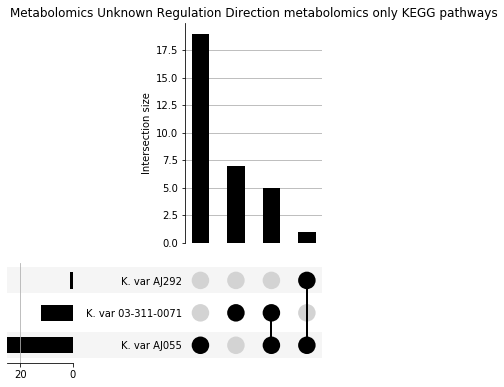

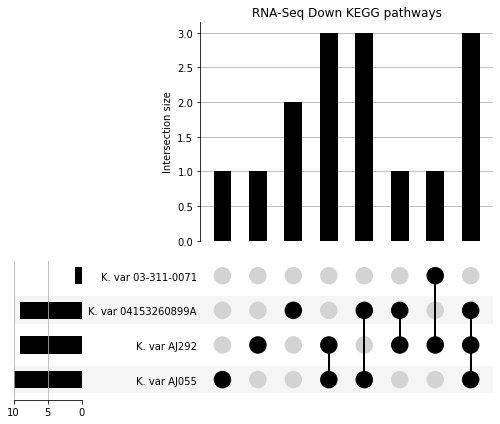

Metabolomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Alanine, aspartate and glutamate metabolism    2
Aminoacyl-tRNA biosynthesis                    2
Galactose metabolism                           2
Lysine biosynthesis                            2
Streptomycin biosynthesis                      2
Biotin metabolism                              2
Name: intersections_count, dtype: int64 

RNA-Seq = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Amino sugar and nucleotide sugar metabolism    3
Inositol phosphate metabolism                  3
Starch and sucrose metabolism                  3
Name: intersections_count, dtype: int64 

Metabolomics Unknown Regulation Direction metabolomics only = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Alanine, aspartate and glutamate metabolism    2
Aminoacyl-tRNA biosynthesis                    2
Galactose metabolism                           2
Lysine biosynthesis   

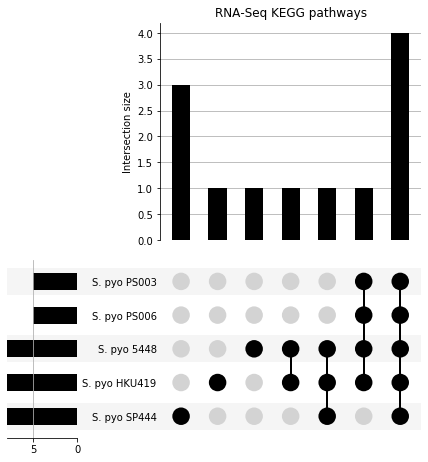

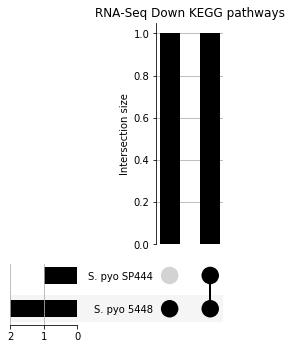

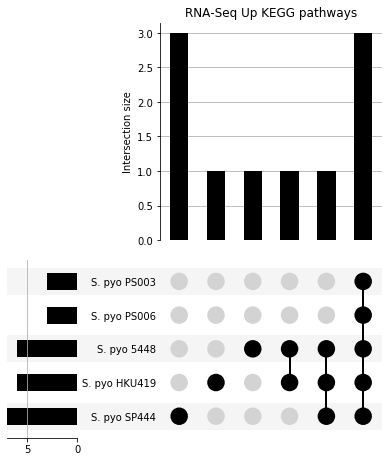

RNA-Seq = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Galactose metabolism               5
Phosphotransferase system (PTS)    5
Ribosome                           5
Starch and sucrose metabolism      5
Name: intersections_count, dtype: int64 

RNA-Seq Down = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Ribosome    2
Name: intersections_count, dtype: int64 

RNA-Seq Up = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Galactose metabolism               5
Phosphotransferase system (PTS)    5
Starch and sucrose metabolism      5
Name: intersections_count, dtype: int64 

Metabolomics as one plot
RNA-Seq as one plot
Metabolomics Unknown Regulation Direction metabolomics only as one plot
RNA-Seq Down as one plot
RNA-Seq Up as one plot


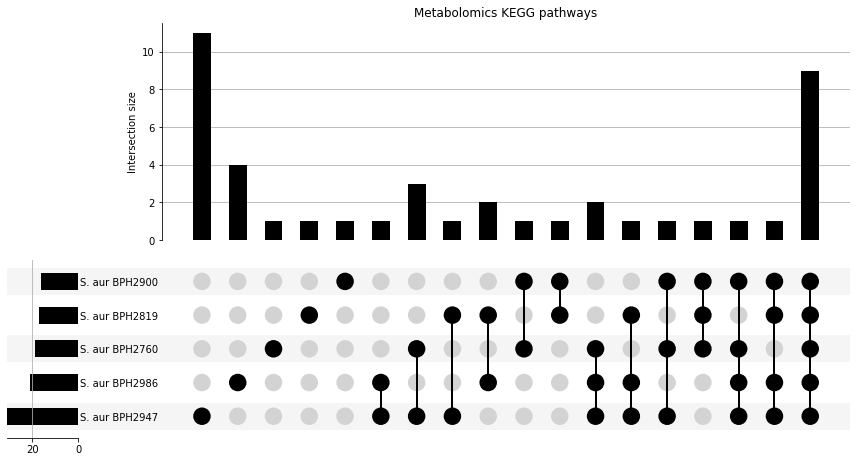

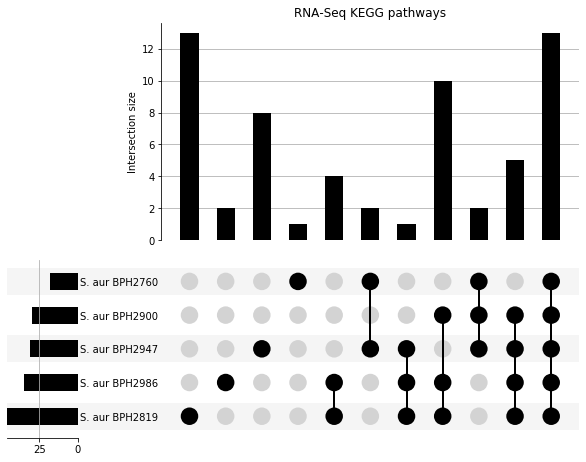

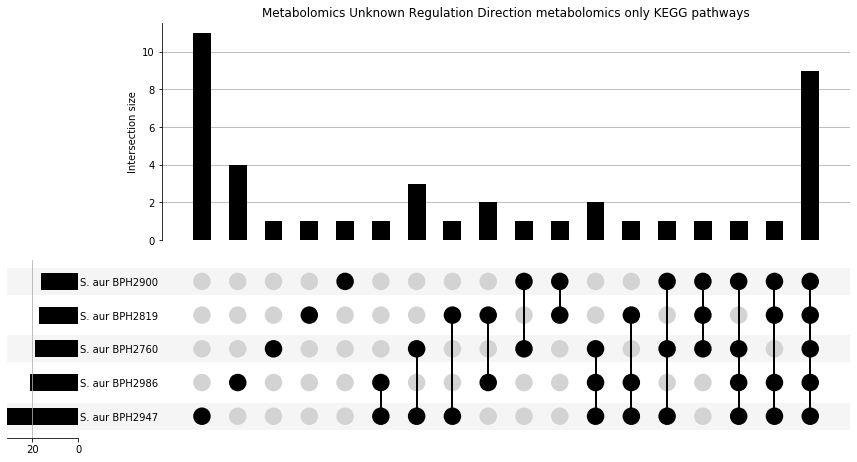

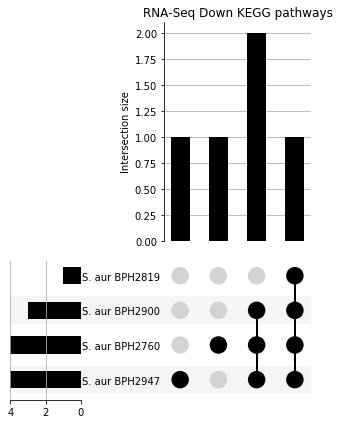

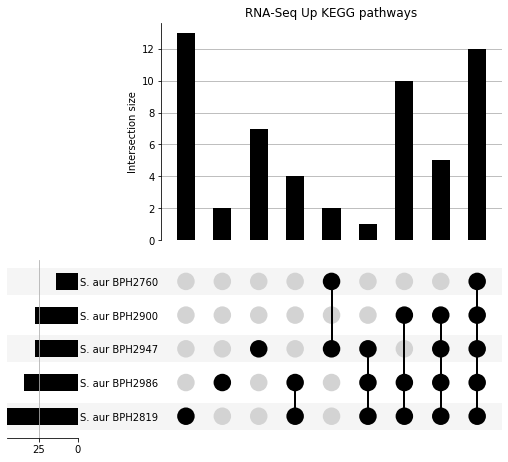

Metabolomics = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Aminoacyl-tRNA biosynthesis                    5
Arginine and proline metabolism                5
Cysteine and methionine metabolism             5
Galactose metabolism                           5
Glycine, serine and threonine metabolism       5
Lysine biosynthesis                            5
Streptomycin biosynthesis                      5
Sulfur metabolism                              5
Valine, leucine and isoleucine biosynthesis    5
Name: intersections_count, dtype: int64 

RNA-Seq = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Amino sugar and nucleotide sugar metabolism     5
Ascorbate and aldarate metabolism               5
Fructose and mannose metabolism                 5
Galactose metabolism                            5
Glycerolipid metabolism                         5
Methane metabolism                              5
Microbial metabolism in diverse environments  

In [12]:
for data in species:
    pooled_data_omic_for_upsetplot = _reformat_data_for_upsetplot(data, "Type_of_Experiment")
    for i, j in enumerate(pooled_data_omic_for_upsetplot):
        if len(j[1]) < 2:
            print("There are are less than 2 comparable strains for condition:", 
                  data["Species"].unique().tolist()[0], j[0], "- removing!")
            del pooled_data_omic_for_upsetplot[i]

    pooled_data_omic_direction_for_upsetplot = _reformat_data_for_upsetplot(data, "Type_of_Experiment_Direction")
    for i, j in enumerate(pooled_data_omic_direction_for_upsetplot):
        if len(j[1]) < 2:
            print("There are are less than 2 comparable strains for condition:", 
                  data["Species"].unique().tolist()[0], j[0], "- removing!")
            del pooled_data_omic_direction_for_upsetplot[i]
                           
    _make_upsetplot(pooled_data_omic_for_upsetplot, "Type_of_Experiment")        
    _make_upsetplot(pooled_data_omic_direction_for_upsetplot, "Type_of_Experiment_Direction")
    
    quantile = 0.95
    most_intersections = list()
    for name, path in pooled_data_omic_for_upsetplot:
        most_intersections.append((name, extract_pathway_by_intersections(path, quantile)))

    # export tsv files of pathways:quantity of intersections across strains
    for name, path in most_intersections:
        print(name, "= quantile", quantile, "of pathways which overlap across strains:\n", path["intersections_count"], "\n")
        path.to_csv("_".join(["_".join(data["Species"].unique().tolist()[0].split(" ")), 
                              "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")

    quantile = 0.95
    most_intersections = list()
    for name, path in pooled_data_omic_direction_for_upsetplot:
        most_intersections.append((name, extract_pathway_by_intersections(path, quantile)))

    # export tsv files of pathways:quantity of intersections across strains
    for name, path in most_intersections:
        print(name, "= quantile", quantile ,"of pathways which overlap across strains:\n", path["intersections_count"], "\n")
        path.to_csv("_".join(["_".join(data["Species"].unique().tolist()[0].split(" ")), 
                              "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")

### Notes on data <a name="notes"></a>

#### Presence of null values in camera data
2020 PValues and corresponding FDR are null in the camera analysis. These were dropped from the dataset. An example table is below to illustrate.

In [13]:
camera_withna = pandas.read_csv(camera_path, sep="\t")
camera_withna[camera_withna["PValue"].isnull()].head()

Empty DataFrame
Columns: [Species, Strain, Type_of_Experiment, entity_type, contrast, kegg_pathway_id, NGenes, Direction, PValue, FDR, kegg_pathway_name]
Index: []

#### Rescuing metabolomics data by merging regulation states

Metabolomics Up and Down regulated data is sparse after filtering and deduplicating values. This is partly because some of the third party software used to obtain results does not return information regarding regulation state. Merging Up and Down regulated data with the Unknown data is one possible workaround for this.



In [14]:
print("After processing deduplicated and filtered data")
print("Number of entries in metabolomics upregulated state:", str(metabolomics_up.shape[0]))
print("Number of entries in metabolomics downregulated state:", str(metabolomics_dn.shape[0]))
print("Number of entries in metabolomics unknown regulation state:", str(metabolomics_un.shape[0]))

After processing deduplicated and filtered data
Number of entries in metabolomics upregulated state: 0
Number of entries in metabolomics downregulated state: 0
Number of entries in metabolomics unknown regulation state: 338


#### Removal of some conditions
Any condition with less than 2 strains present which had overlapping pathways were removed as they are not comparable.

#### Pathways present in just one dataset are counted

The pathways reported in the Upset plot represents a 'union' of all the significant pathways identified in all the -omics results. For example, if fatty acid biosynthesis is identified to be significant in the proteomics data of one strain and not in the transcriptomics data of the same strain, it will still be counted as significant for that strain.